In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import urllib.request
import matplotlib.pyplot as plt
from scipy.stats import zscore

In [289]:
list_metricas = ['average_clustering', 'coefficient_distribution_degree', 'density', 'average_degree', 'average_short_path']#, 'number_of_nodes']
list_metricas = ['average_clustering']

list_variables_a = [
    #'Patrimonio_Liquido',
    #'Cotas_Emitidas',
    #'Valor_Patrimonial_Cotas',
    'Percentual_Rentabilidade_Efetiva_Mes',
    'Percentual_Rentabilidade_Patrimonial_Mes',
    #'Percentual_Dividend_Yield_Mes',
    #'Percentual_Amortizacao_Cotas_Mes',
]


list_variables_b = [
    'Valor_Ativo',
    'Percentual_Despesas_Taxa_Administracao',
    'Percentual_Despesas_Agente_Custodiante',
    'Total_Necessidades_Liquidez',
    'Disponibilidades',
    'Titulos_Publicos',
    'Titulos_Privados',
    'Fundos_Renda_Fixa',
    'Total_Investido',
    'Direitos_Bens_Imoveis',
    'Terrenos',
    'Imoveis_Renda_Acabados',
    'Imoveis_Renda_Construcao',
    'Imoveis_Venda_Acabados',
    'Imoveis_Venda_Construcao',
    'Outros_Direitos_Reais',
    'Acoes',
    'Debentures',
    'Bonus_Subscricao',
    'Certificados_Deposito_Valores_Mobiliarios',
    'Cedulas_Debentures',
    'Fundo_Acoes',
    'FIP',
    'FII',
    'FDIC',
    'Outras_Cotas_FI',
    'Notas_Promissorias',
    'Acoes_Sociedades_Atividades_FII',
    'Cotas_Sociedades_Atividades_FII',
    'CEPAC',
    'CRI',
    'Letras_Hipotecarias',
    'LCI',
    'LIG',
    'Outros_Valores_Mobliarios',
    'Valores_Receber',
    'Contas_Receber_Aluguel',
    'Contas_Receber_Venda_Imoveis',
    'Outros_Valores_Receber',
    'Rendimentos_Distribuir',
    'Taxa_Administracao_Pagar',
    'Taxa_Performance_Pagar',
    'Obrigacoes_Aquisicao_Imoveis',
    'Adiantamento_Venda_Imoveis',
    'Adiantamento_Alugueis',
    'Obrigacoes_Securitizacao_Recebiveis',
    'Instrumentos_Financeiros_Derivativos',
    'Provisoes_Contigencias',
    'Outros_Valores_Pagar',
    'Total_Passivo',
 ]

list_variables =  list_variables_b #list_variables_a +

list_cat = [
    'Mandato',
    'Segmento_Atuacao',
    'Publico_Alvo',
    'Tipo_Gestao',
]

ds_fii = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0)
df_dados_fii = pd.read_csv('dataset/cvm/dataset_cvm_metrica_mensal_dados.csv', index_col='CNPJ_Fundo')

df_fii = ds_fii.to_array().stack(var=['variable', 'metrica']).to_pandas()

df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]] = df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]][df_fii[[ (v, 'coefficient_distribution_degree') for v in list_variables ]].apply(zscore).abs() <= 1].fillna(0)
df_fii_cat =  df_dados_fii[list_cat]

df_fii = df_fii[ [ (v, m) for v in list_variables for m in list_metricas ] ]
df_fii[['TIR']] = df_dados_fii[['TIR']][df_dados_fii[['TIR']].fillna(0).apply(zscore).abs() <= 1].fillna(0)

cnpj_meses = xr.open_dataset('dataset/cvm/dataset_cvm_metrica_mensal.nc').fillna(0).Acoes.sel(metrica='number_of_nodes').to_pandas()

In [290]:
import copy

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

In [291]:
def dataset_filter(df, tamanho_series):
    list_cnpj = cnpj_meses[cnpj_meses >= tamanho_series].index.values
    df_out = df[df.index.isin(list_cnpj)]
    
    return df_out

In [292]:
def select_features_rfr(df_fii, tamanho_series, num_test=10):
    df_fii_filter = dataset_filter(df_fii, tamanho_series)
    
    df_features = df_fii_filter.drop(columns=[('TIR', '')])
    df_target = df_fii_filter[('TIR', '')]
    
    prep = OneHotEncoder()
    prep.fit(df_dados_fii[df_dados_fii.index.isin(df_fii_filter.index.values)][list_cat])
    
    preprocessing = prep.transform(df_dados_fii[df_dados_fii.index.isin(df_fii_filter.index.values)][list_cat]).toarray()
    
    X_train, X_test, y_train, y_test = train_test_split(np.hstack((df_features, preprocessing)), df_target, train_size=2/3)
    
    rfr = RandomForestRegressor(n_estimators=X_train.shape[1]*2, n_jobs=-1)
    
    prep_cols = []
    for i in prep.categories_:
        prep_cols += list(i)
        
    df_features_values = pd.DataFrame(index=list(df_features.columns.values) + prep_cols)
    mae_erros = []
    medae_erros = []
    
    for i in range(num_test):
        print(f'{i+1:2d}/{num_test:2d}')
        rfr.fit(X_train, y_train)
        mae_erros.append( mean_absolute_error(y_test, rfr.predict(X_test)) )
        medae_erros.append( median_absolute_error(y_test, rfr.predict(X_test)) )
        
        df_features_values[f'model_{i}'] = pd.DataFrame(data=rfr.feature_importances_, index=df_features_values.index.values, columns=[f'model_{i}'])
    return df_features_values.T, mae_erros, medae_erros

# Resultados

Gráfico por classificação

In [293]:
dict_data = {}

for i in range(0, 73):
    print(i)
    dict_data[i] = select_features_rfr(df_fii, i, 10)

0
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
1
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
2
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
3
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
4
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
5
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
6
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
7
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
8
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
9
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
10
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
11
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
12
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
13
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
14
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
15
 1/10
 2/10
 3/10
 4/10
 5/10
 6/10
 7/10
 8/10
 9/10
10/10
16

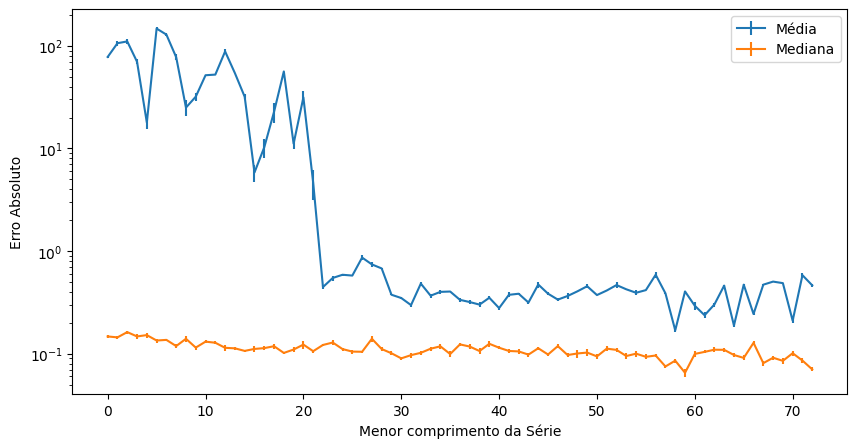

In [297]:
x = []
y1 = []
y11 = []
y2 = []
y21 = []

plt.figure(figsize=(10,5))

for i in range(0, 73):
    x.append(i)
    y1.append(np.mean(dict_data[i][1]))
    y11.append(np.std(dict_data[i][1]))
    y2.append(np.mean(dict_data[i][2]))
    y21.append(np.std(dict_data[i][2]))
    
    for i in dict_data[periodo][0].columns.values:
        if type(i) == type(tuple()):
            multiindex.append(i)
        else:
            multiindex.append((i, ''))

    mi = pd.MultiIndex.from_tuples(multiindex, names=('variable', 'metric'))

x = np.asarray(x)
y1 = np.asarray(y1)
y11 = np.asarray(y11)
y2 = np.asarray(y2)
y21 = np.asarray(y21)

plt.errorbar(x, y1, y11, fmt='-', label='Média')
plt.errorbar(x, y2, y21, fmt='-', label='Mediana')
#plt.xticks(x)
plt.xlabel('Menor comprimento da Série')
plt.ylabel('Erro Absoluto')
plt.yscale('log')
plt.legend(loc='best')
plt.show()

In [341]:
periodo = 60

multiindex = []

for i in dict_data[periodo][0].columns.values:
    if type(i) == type(tuple()):
        multiindex.append(i)
    else:
        multiindex.append((i, ''))

dict_data[periodo][0].columns = pd.MultiIndex.from_tuples(multiindex, names=('variable', 'metric'))
dict_data[periodo][0].mean().groupby(level=[0]).sum()

variable
Acoes                              0.003786
Acoes_Sociedades_Atividades_FII    0.041409
Adiantamento_Alugueis              0.014631
Adiantamento_Venda_Imoveis         0.003207
Ativa                              0.001614
                                     ...   
Total_Passivo                      0.015499
Títulos e Val. Mob.                0.001662
Títulos e Valores Mobiliários      0.001397
Valor_Ativo                        0.011338
Valores_Receber                    0.030922
Length: 69, dtype: float64

<Axes: title={'center': 'Variáveis mais relevantes'}, xlabel='Importância (%)', ylabel='Variáveis'>

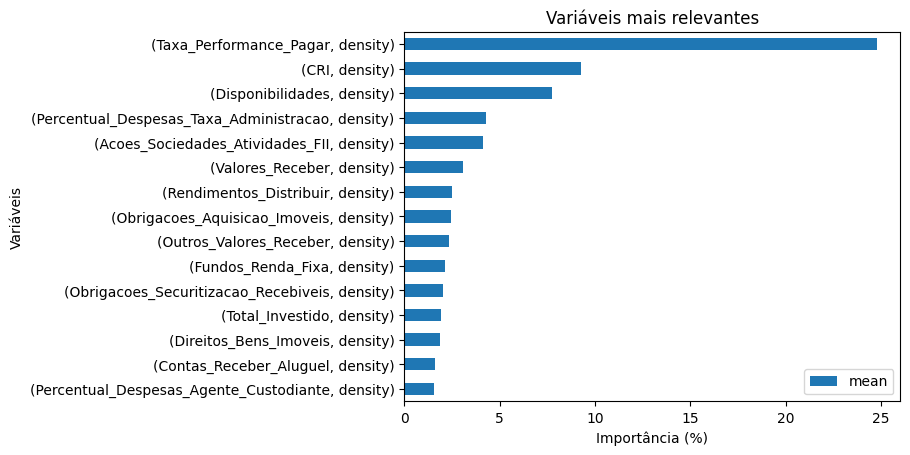

In [298]:
periodo = 60
(dict_data[periodo][0].agg(['mean', 'std']).T.sort_values('mean', ascending=False)[['mean']].head(15).sort_values('mean', ascending=True)*100).gr.plot.barh(xlabel='Importância (%)', ylabel='Variáveis', title='Variáveis mais relevantes')

In [296]:
periodo = 60
dict_data[periodo][0].agg(['mean', 'std']).T.sort_values('mean', ascending=True).query('mean <= 0.00001').astype(float)

,mean,std
Hospital,0.000003,0.000004
